In [1]:
import tensorflow as tf

In [2]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import numpy as np
import cv2
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D,Dense,Dropout,SpatialDropout2D
from tensorflow.keras.models  import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
import random,os,glob
import matplotlib.pyplot as plt

In [4]:
os.listdir(os.path.join(os.getcwd(),"dataset-resized"))

['plastic', 'glass', 'cardboard', 'paper', '.DS_Store', 'metal', 'trash']

In [5]:
train_aug = ImageDataGenerator(shear_range=0.1,
                               vertical_flip=True,
                               horizontal_flip=True,
                               validation_split=0.1,
                               zoom_range=0.3,
                               width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               rescale=1./255)

path = os.path.join(os.getcwd(),"dataset-resized")

train_set=train_aug.flow_from_directory(path,
                                    target_size=(312,312),
                                    batch_size=32,
                                    class_mode='categorical',
                                    subset='training')

Found 2337 images belonging to 6 classes.


In [6]:
labels = (train_set.class_indices)
print(labels)

labels = dict((v,k) for k,v in labels.items())
print(labels)

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


In [7]:
test=ImageDataGenerator(rescale=1/255,
                        validation_split=0.2)                      

test_set=test.flow_from_directory(path,
                                  target_size=(312,312),
                                  batch_size=32,
                                  class_mode='categorical',
                                  subset='validation')

Found 517 images belonging to 6 classes.


In [8]:
for image_batch, label_batch in train_set:
  break
image_batch.shape, label_batch.shape

((32, 312, 312, 3), (32, 6))

# Writing the labels file

In [9]:
print (train_set.class_indices)

Labels = '\n'.join(sorted(train_set.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(Labels)

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


# Building CNN

In [10]:
model=Sequential()
#Convolution blocks

model.add(Conv2D(32,(3,3), padding='same',input_shape=(312,312,3),activation='relu'))
model.add(MaxPooling2D(pool_size=2)) 
#model.add(SpatialDropout2D(0.5)) # No accuracy

model.add(Conv2D(64,(3,3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2)) 
#model.add(SpatialDropout2D(0.5))

model.add(Conv2D(32,(3,3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2)) 

#Classification layers
model.add(Flatten())

model.add(Dense(64,activation='relu'))

#model.add(Dropout(0.2))
model.add(Dense(32,activation='relu'))

#model.add(Dropout(0.2))
model.add(Dense(6,activation='softmax'))

In [11]:
filepath='trained_model_CNN_v2.h5'
checkpoint1 = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint1]

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 312, 312, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 156, 156, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 156, 156, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 78, 78, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 78, 78, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 39, 39, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 48672)             0

# Compiling Model

In [13]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc']) # RMS PROP - No accuracy

#es=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

# Train

In [ ]:
history = model.fit_generator(train_set,
                              epochs=55,
                              steps_per_epoch=2337//32,
                              validation_data=test_set,
                              validation_steps=517//32,
                              workers = 4,
                              callbacks=callbacks_list)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 73 steps, validate for 16 steps
Epoch 1/55
72/73 [============================>.] - ETA: 0s - loss: 0.5309 - acc: 0.8038
Epoch 00001: val_acc did not improve from 0.77734
73/73 [==============================] - 15s 206ms/step - loss: 0.5303 - acc: 0.8039 - val_loss: 0.7185 - val_acc: 0.7773
Epoch 2/55
72/73 [============================>.] - ETA: 0s - loss: 0.5547 - acc: 0.7941
Epoch 00002: val_acc did not improve from 0.77734
73/73 [==============================] - 15s 207ms/step - loss: 0.5541 - acc: 0.7944 - val_loss: 0.7908 - val_acc: 0.7227
Epoch 3/55
72/73 [============================>.] - ETA: 0s - loss: 0.5048 - acc: 0.8121
Epoch 00003: val_acc did not improve from 0.77734
73/73 [==============================] - 15s 206ms/step - loss: 0.5041 - acc: 0.8126 - val_loss: 0.6456 - val_acc: 0.7754
Epoch 4/55
72/73 [============================>.] - ETA: 0s - loss: 0.5135 - acc: 0.8095
Epoch 00004: val_acc did not improve

Maximum Probability:  0.99997234
Classified: plastic


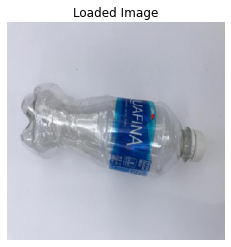

In [15]:
from tensorflow.keras.preprocessing import image

img_path = os.path.join(os.getcwd(),"dataset-resized/plastic/plastic49.jpg")

img = image.load_img(img_path, target_size=(312,312))
img = image.img_to_array(img, dtype=np.uint8)
img=np.array(img)/255.0

plt.title("Loaded Image")
plt.axis('off')
plt.imshow(img.squeeze())

p=model.predict(img[np.newaxis, ...])

#print("Predicted shape",p.shape)
print("Maximum Probability: ",np.max(p[0], axis=-1))
predicted_class = labels[np.argmax(p[0], axis=-1)]
print("Classified:",predicted_class)


-------------------Individual Probability--------------------------------

CARDBOARD : 0.0 %
GLASS : 0.0 %
METAL : 0.0 %
PAPER : 0.0 %
PLASTIC : 100.0 %
TRASH : 0.0 %


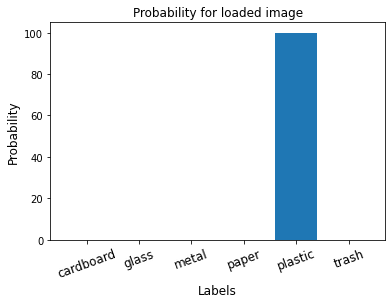

In [16]:
classes=[]
prob=[]
print("\n-------------------Individual Probability--------------------------------\n")

for i,j in enumerate (p[0],0):
    print(labels[i].upper(),':',round(j*100,2),'%')
    classes.append(labels[i])
    prob.append(round(j*100,2))
    
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(classes))
    plt.bar(index, prob)
    plt.xlabel('Labels', fontsize=12)
    plt.ylabel('Probability', fontsize=12)
    plt.xticks(index, classes, fontsize=12, rotation=20)
    plt.title('Probability for loaded image')
    plt.show()
plot_bar_x()

"""## Accuracy Graph"""

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

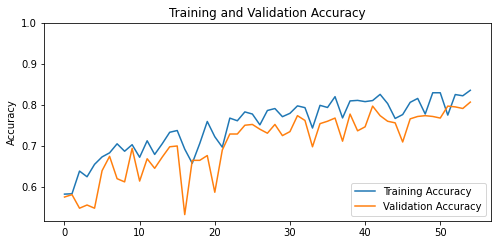

In [17]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

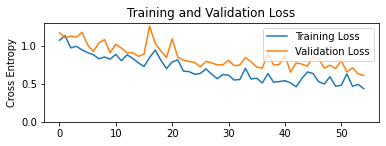

In [18]:
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()
